In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad  # Make sure to import anndata
import matplotlib.pyplot as pl
import seaborn as sns
import bbknn
import scvelo as scv
import anndata
import leidenalg
import loompy
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
from matplotlib.pyplot import rc_context
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os
import random
import mellon

In [2]:
import os
import scanpy as sc
import numpy as np
import anndata  # Ensure to import anndata

# Set working directory
os.chdir("P:/Tolulope/Manuscript/Yuan Analysis")

# List of .h5ad files and corresponding sample names
samples = {
    'YSham_GFP_adata_filtered_with_SOLO.h5ad': 'YSham_GFP',
    'YSham_noGFP_adata_filtered_with_SOLO.h5ad': 'YSham_noGFP',
    'YOV_GFP_adata_filtered_with_SOLO.h5ad': 'YOV_GFP',
    'YOV_noGFP_adata_filtered_with_SOLO.h5ad': 'YOV_noGFP',
    'ASham_GFP_adata_filtered_with_SOLO.h5ad': 'ASham_GFP',
    'ASham_noGFP_adata_filtered_with_SOLO.h5ad': 'ASham_noGFP',
    'AOV_GFP_adata_filtered_with_SOLO.h5ad': 'AOV_GFP',
    'AOV_noGFP_adata_filtered_with_SOLO.h5ad': 'AOV_noGFP'
}

# Define preprocessing function
def preprocess_adata(adata):
    """Preprocess an AnnData object while keeping the original data intact in .raw."""
    
    # Save raw data in adata.raw before filtering and preprocessing
    if not hasattr(adata, 'raw'):
        adata.raw = adata.copy()  # Create a deep copy of the AnnData object

    adata.var_names_make_unique()  # Ensure gene names are unique
    
    # Filter cells and genes but do so after saving raw data
    sc.pp.filter_cells(adata, min_genes=200)  # Remove cells with <200 genes
    sc.pp.filter_genes(adata, min_cells=3)  # Remove genes found in <3 cells

    # Annotate mitochondrial genes
    adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
    
    # Identify hemoglobin genes, excluding those starting with "HbP"
    adata.var['hb'] = adata.var_names.str.contains(r'^Hb(?!P)', regex=True)
    
    # Remove hemoglobin genes
    adata = adata[:, ~adata.var['hb']]

    # Calculate quality control (QC) metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

    # Remove cells with high mitochondrial content (>10%)
    adata = adata[adata.obs.pct_counts_mt < 10]

    return adata


In [2]:
import os
import scanpy as sc
import numpy as np
import anndata  # Ensure to import anndata

# Set working directory
os.chdir("P:/Tolulope/Manuscript/Yuan Analysis")

# List of .h5ad files and corresponding sample names
samples = {
    'YSham_GFP_adata_filtered_with_SOLO.h5ad': 'YSham_GFP',
    'YSham_noGFP_adata_filtered_with_SOLO.h5ad': 'YSham_noGFP',
    'YOV_GFP_adata_filtered_with_SOLO.h5ad': 'YOV_GFP',
    'YOV_noGFP_adata_filtered_with_SOLO.h5ad': 'YOV_noGFP',
    'ASham_GFP_adata_filtered_with_SOLO.h5ad': 'ASham_GFP',
    'ASham_noGFP_adata_filtered_with_SOLO.h5ad': 'ASham_noGFP',
    'AOV_GFP_adata_filtered_with_SOLO.h5ad': 'AOV_GFP',
    'AOV_noGFP_adata_filtered_with_SOLO.h5ad': 'AOV_noGFP'
}

# Define preprocessing function
def preprocess_adata(adata):
    """Preprocess an AnnData object while keeping the original data intact in .raw."""
    
    # Create a raw layer to preserve the original data as an AnnData object
    adata.raw = anndata.AnnData(X=adata.X.copy(), var=adata.var.copy(), obs=adata.obs.copy())  # Ensure raw is initialized correctly
    
    adata.var_names_make_unique()  # Ensure gene names are unique
    
    # Filter cells and genes but do so after saving raw data
    sc.pp.filter_cells(adata, min_genes=200)  # Remove cells with <200 genes
    sc.pp.filter_genes(adata, min_cells=3)  # Remove genes found in <3 cells

    # Annotate mitochondrial genes
    adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
    
    # Identify hemoglobin genes, excluding those starting with "HbP"
    adata.var['hb'] = adata.var_names.str.contains(r'^Hb(?!P)', regex=True)
    
    # Remove hemoglobin genes
    adata = adata[:, ~adata.var['hb']]

    # Calculate quality control (QC) metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

    # Remove cells with high mitochondrial content (>5%)
    adata = adata[adata.obs.pct_counts_mt < 5]

    return adata

In [3]:
# Process each file and store preprocessed objects
out = []
for file, sample_name in samples.items():
    file_path = os.path.join("P:/Tolulope/Manuscript/Yuan Analysis", file)
    if os.path.exists(file_path):  # Ensure file exists
        adata = sc.read_h5ad(file_path)  # Load .h5ad file
        adata = preprocess_adata(adata)  # Preprocess the data
        adata.obs["Sample"] = sample_name  # Assign sample name
        out.append(adata)  # Append preprocessed data to list
    else:
        print(f"File not found: {file_path}")

In [4]:
# Concatenate the list of preprocessed AnnData objects
if out:
    adata_concat = anndata.concat(out, label="Sample", keys=list(samples.values()))
    results_file = 'adata_concat.h5ad'
    adata_concat.layers['counts'] = adata_concat.X.copy()
    adata_concat.write(results_file)

    # Display the number of cells in each sample
    print(adata_concat.obs['Sample'].value_counts())

    # Ensure raw data is preserved by copying after all preprocessing
    # Raw is already preserved during the preprocessing step

    # Now proceed with the analysis on filtered data
    adata = adata_concat.copy()

    # Normalize and log-transform data
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Identify highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]
    sc.pp.regress_out(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'])
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata)

else:
    print("No valid AnnData files to process.")

Sample
ASham_noGFP    12490
AOV_noGFP      11056
AOV_GFP         8063
YSham_noGFP     7380
YOV_noGFP       7219
YOV_GFP         4044
YSham_GFP       2355
ASham_GFP       1902
Name: count, dtype: int64


In [5]:
# Apply Harmony integration (before PCA or other dimensionality reductions)
kwargs = dict(verbose=True, plot_convergence=True, max_iter_kmeans=25)
sc.external.pp.harmony_integrate(adata, key='batch', **kwargs)

# Run nearest neighbors using the Harmony-corrected PCA
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_neighbors=30, n_pcs=50)
sc.tl.leiden(adata, resolution=0.9)
sc.tl.umap(adata)

2025-03-26 10:32:41,464 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-26 10:32:50,270 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-26 10:32:50,552 - harmonypy - INFO - Iteration 1 of 10
2025-03-26 10:33:17,378 - harmonypy - INFO - Iteration 2 of 10
2025-03-26 10:33:44,041 - harmonypy - INFO - Iteration 3 of 10
2025-03-26 10:34:11,245 - harmonypy - INFO - Converged after 3 iterations


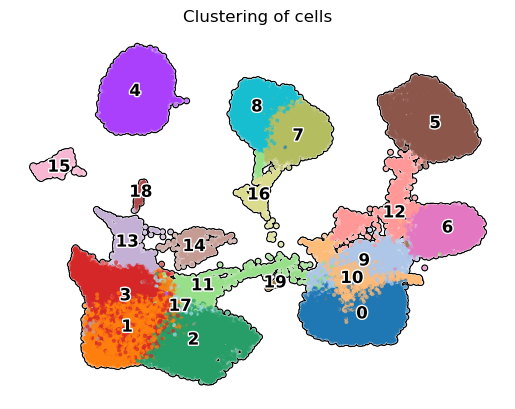

In [6]:
# Plot UMAP with the clustering results
sc.pl.umap(adata, color='leiden', add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, size=35,
           title='Clustering of cells')

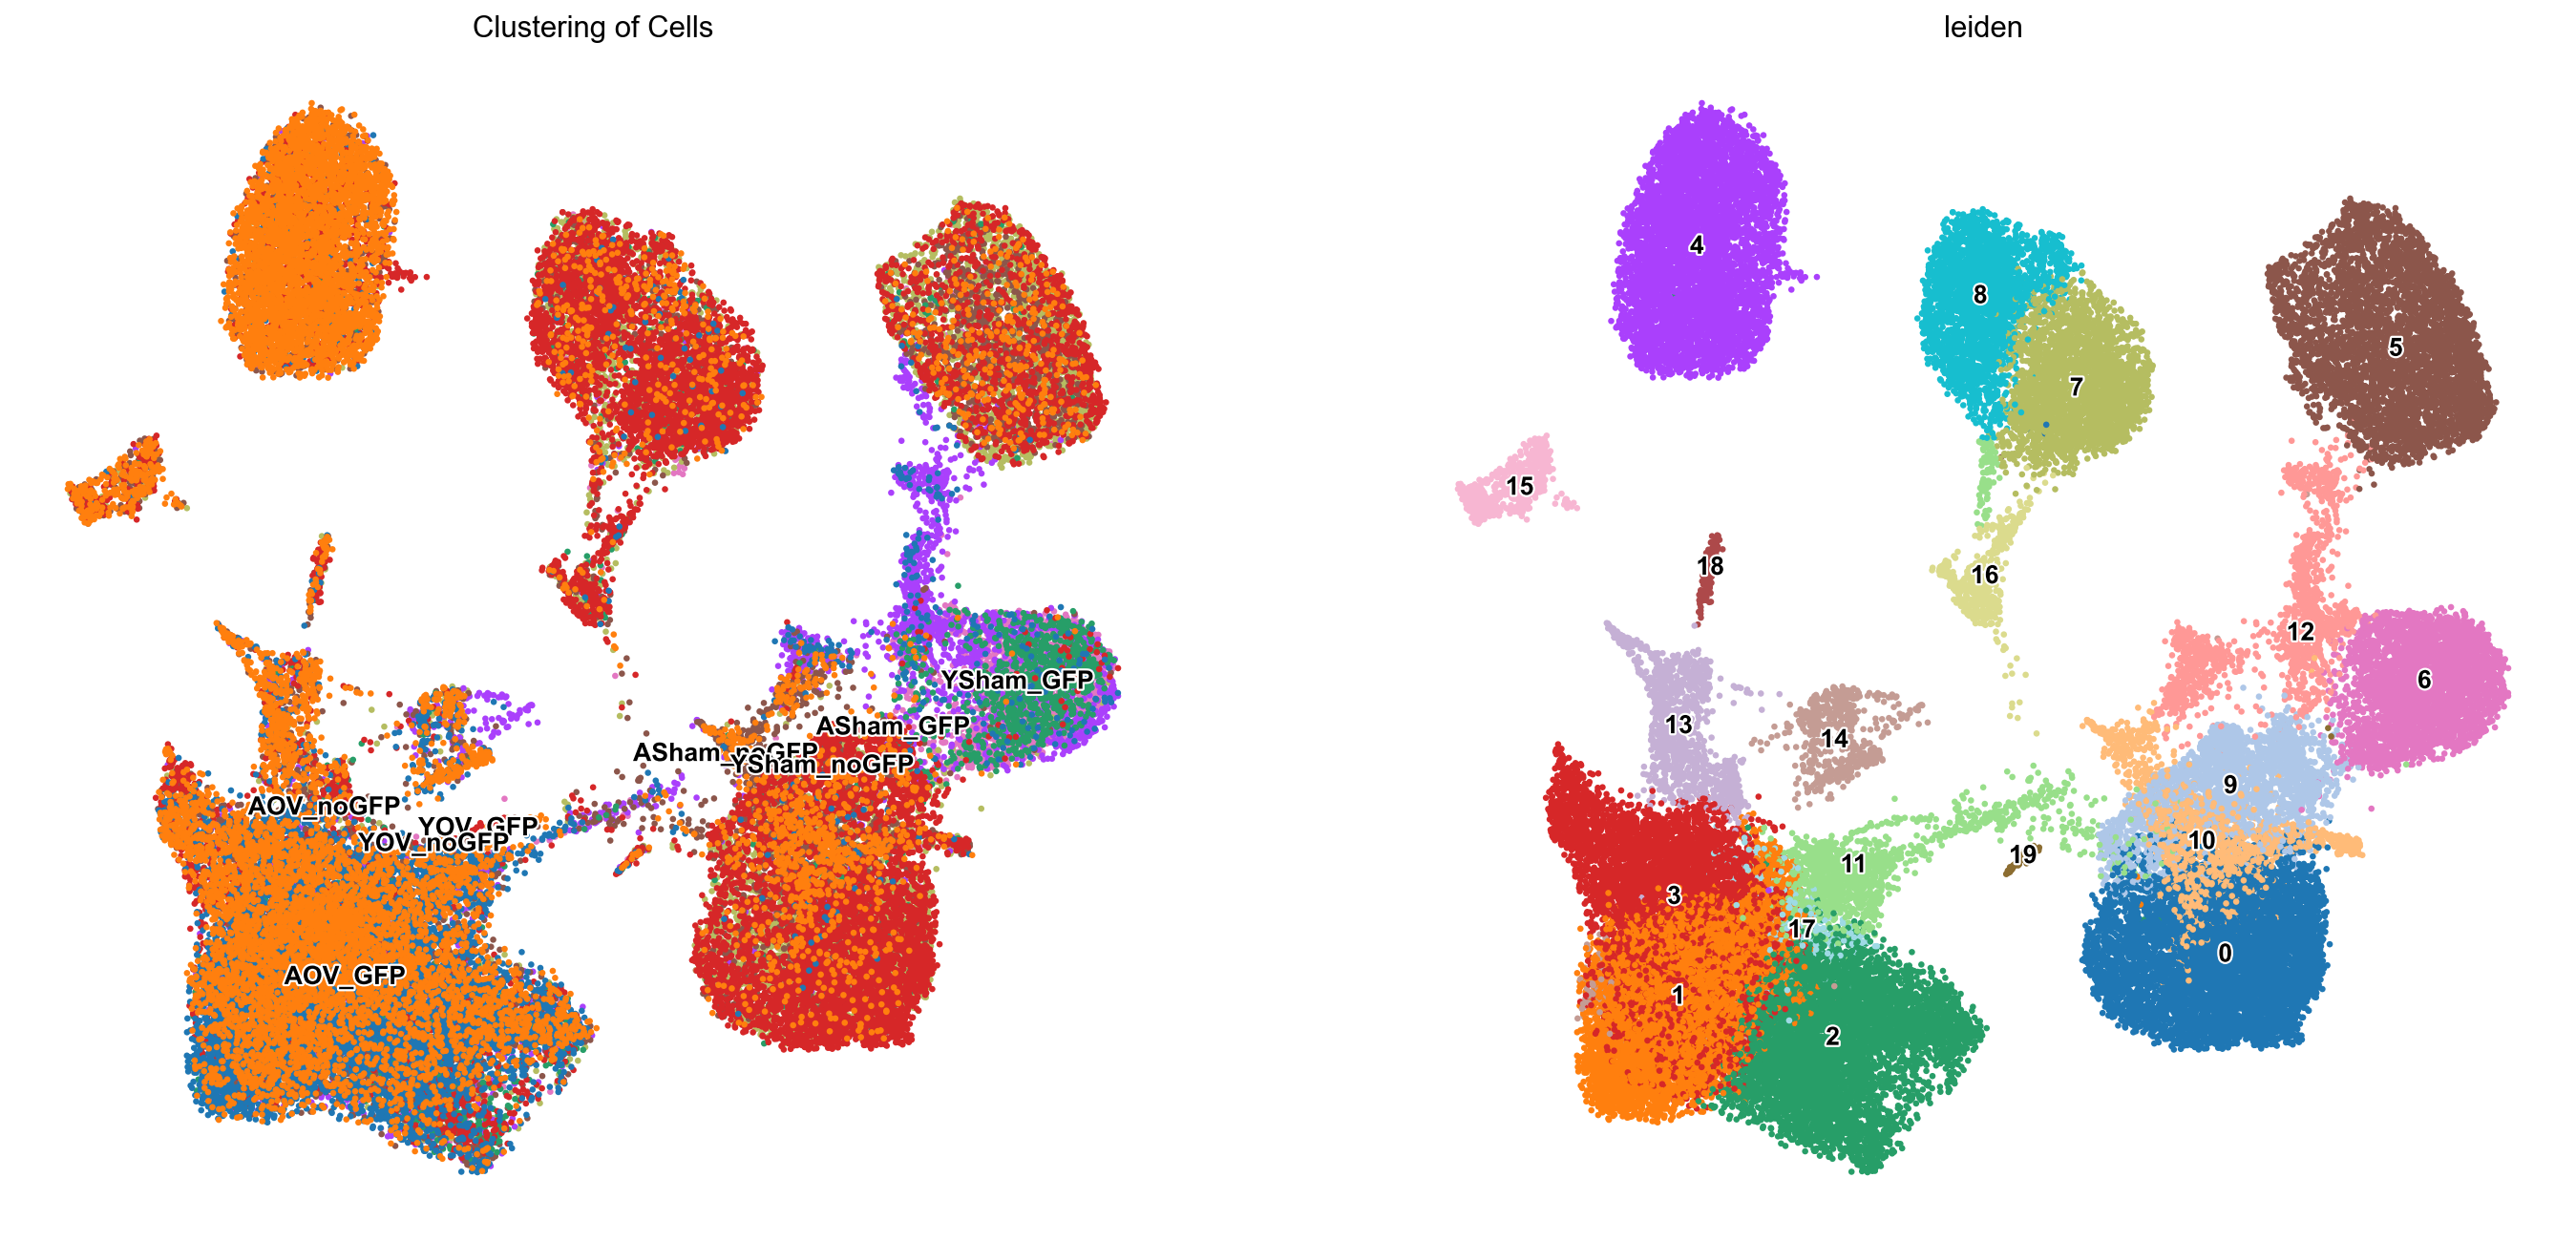

In [7]:
# Customize UMAP plot
sc.set_figure_params(figsize=(10, 10))
img_tag = "_color"  # Specify your image tag here
sc.pl.umap(adata, color=['batch', 'leiden'], legend_loc='on data', legend_fontsize=12, legend_fontoutline=2, frameon=False, size=35, title='Clustering of Cells', save=f'umap_plot after integration sample and cell type{img_tag}.png')
pl.show()

In [8]:
adata.write('Ha_integrated_data.h5ad')
adata_concat=adata.copy()

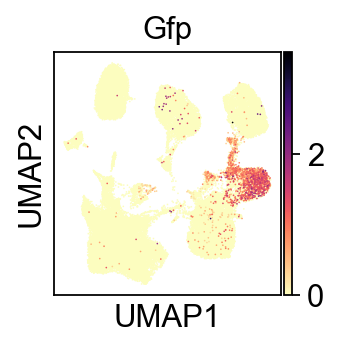

In [9]:
# Set figure size
pl.rcParams['figure.figsize'] = 2, 2
img_tag = "_color"  # Specify your image tag here
# Create the UMAP plot and save it
sc.pl.umap(adata_concat, color='Gfp', color_map='magma_r', save=f"umap_Gfp_{img_tag}.png")

KeyError: 'Pax7'

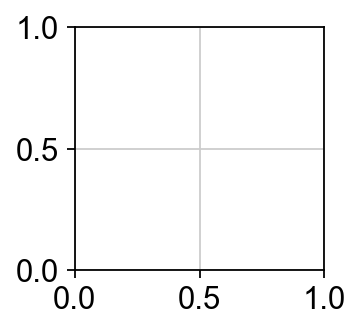

In [10]:
# Set figure size
pl.rcParams['figure.figsize'] = 2, 2

# Create the UMAP plot and save it
sc.pl.umap(adata_concat, color='Pax7', color_map='magma_r', save=f"umap_Pax7_{img_tag}.png")

In [11]:
ad = sc.read("Ha_integrated_data.h5ad")

In [13]:
ad

AnnData object with n_obs × n_vars = 45828 × 3696
    obs: 'batch', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Sample', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

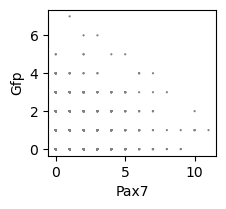

In [12]:
# Set figure size
pl.rcParams['figure.figsize'] = 3, 2
sc.pl.scatter(adata_concat, x="Pax7", y="Gfp",size=10)

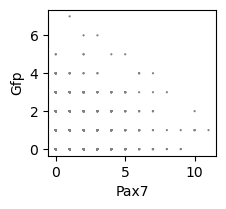

In [15]:
import numpy as np

# Ensure counts are available
if "counts" in ad.layers:
    ad.layers["log_counts"] = np.log1p(adata.layers["counts"])

# Plot using manually log-transformed counts
sc.pl.scatter(ad, x="Pax7", y="Gfp", size=10)


In [3]:
# Set working directory
os.chdir("P:/Tolulope/Manuscript/Yuan Analysis")
adata = sc.read("Ha_integrated_data.h5ad")

In [4]:
adata_concat=adata.copy()

In [11]:
# Now, check the raw attribute of the concatenated data
print(adata_concat.raw)  # Print the raw object
print(adata_concat.raw.var.shape)  # Print the shape of raw gene data


Raw AnnData with n_obs × n_vars = 54509 × 18625
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
(18625, 4)


In [6]:
ad_filtered = adata_concat[(adata_concat.raw[: , "Gfp"].X.toarray().flatten() ==0) , :].copy()
print(ad_filtered)

AnnData object with n_obs × n_vars = 44269 × 3696
    obs: 'batch', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Sample', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'


In [12]:
# Filtering cells where 'Gfp' and 'Pax7' have zero expression in raw data
ad_filtered = adata_concat[
    (adata_concat.raw[:, "Gfp"].X.toarray().flatten() == 0) &  # Filter cells where 'Gfp' expression is 0
    (adata_concat.raw[:, "Pax7"].X.toarray().flatten() == 0),  # Filter cells where 'Pax7' expression is 0
    :
].copy()

# Print the filtered object
print(ad_filtered)

AnnData object with n_obs × n_vars = 43252 × 3696
    obs: 'batch', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Sample', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


In [7]:
sc.tl.embedding_density(ad_filtered, groupby='batch')

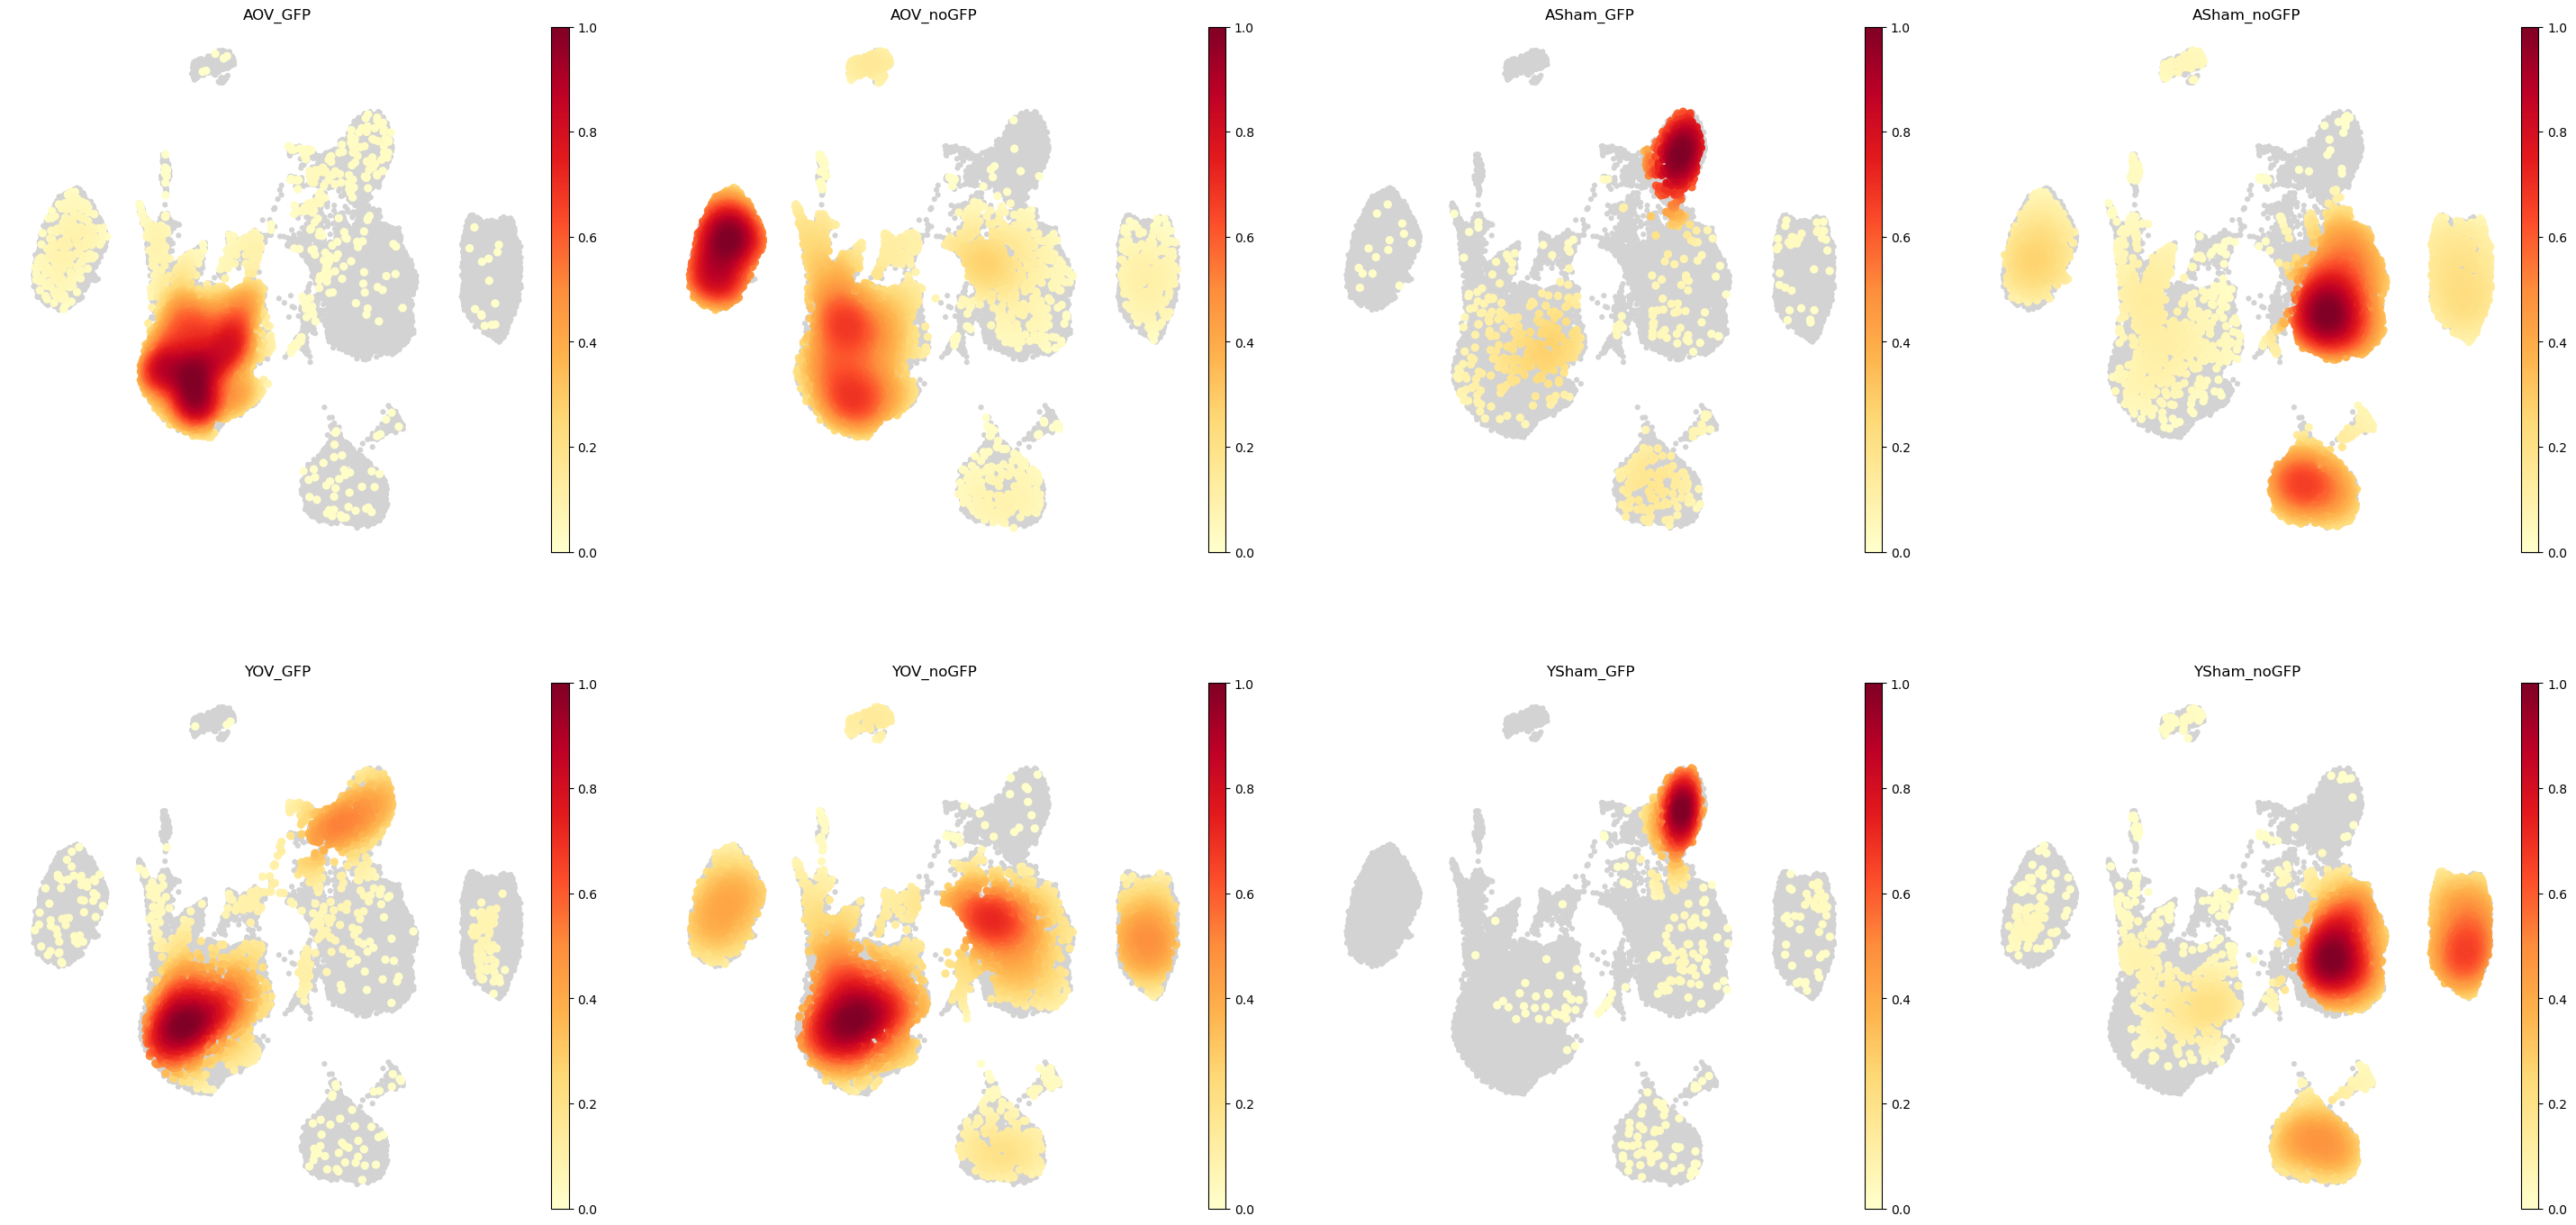

In [9]:
# Set figure size
pl.rcParams['figure.figsize'] = 8, 8
img_tag = "_color"  # Specify your image tag here
sc.pl.embedding_density(ad_filtered, groupby='batch', ncols=4, frameon=False, save=f"umap_densityplot2{img_tag}.png")

In [10]:
ad_filtered.obs[['umap_density_batch','leiden','batch']].to_csv('density_by_cluster_filteredorigfponly.csv')

In [33]:
def preprocess_adata(adata):
    """Preprocess an AnnData object before concatenation."""
    adata.var_names_make_unique()
    sc.pp.filter_cells(adata, min_genes=200)  # Remove cells with <200 genes
    sc.pp.filter_genes(adata, min_cells=3)  # Remove genes found in <3 cells

    # Annotate mitochondrial genes
    adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
    
    # Identify hemoglobin genes, excluding those starting with "HbP"
    adata.var['hb'] = adata.var_names.str.contains(r'^Hb(?!P)', regex=True)
    
    # Remove hemoglobin genes
    adata = adata[:, ~adata.var['hb']]

    # Calculate quality control (QC) metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

    # Remove cells with high mitochondrial content (>5%)
    adata = adata[adata.obs.pct_counts_mt < 5]

    # Save the raw layer (include all genes, including non-variable ones)
    adata.raw = adata.copy()  # Make sure raw includes everything

    return adata


In [34]:
# Process each file and store preprocessed objects
out = []
for file, sample_name in samples.items():
    file_path = os.path.join("P:/Tolulope/Manuscript/Yuan Analysis", file)
    if os.path.exists(file_path):  # Ensure file exists
        adata = sc.read_h5ad(file_path)  # Load .h5ad file
        adata = preprocess_adata(adata)  # Preprocess the data
        adata.obs["Sample"] = sample_name  # Assign sample name
        out.append(adata)  # Append preprocessed data to list
    else:
        print(f"File not found: {file_path}")

# Concatenate the list of preprocessed AnnData objects
if out:
    adata_concat = anndata.concat(out, label="Sample", keys=list(samples.values()))
    results_file = 'adata_concat.h5ad'
    
    # Save the concatenated AnnData object
    adata_concat.write(results_file)

    # Display the number of cells in each sample
    print(adata_concat.obs['Sample'].value_counts())


Sample
AOV_noGFP      10131
ASham_noGFP     9074
YSham_noGFP     6930
YOV_noGFP       6783
AOV_GFP         6231
YOV_GFP         3660
YSham_GFP       1739
ASham_GFP       1280
Name: count, dtype: int64


In [35]:
adata_concat

AnnData object with n_obs × n_vars = 45828 × 18625
    obs: 'batch', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Sample'

In [36]:
# Create a copy for further processing
adata = adata_concat.copy()

# Normalize and log-transform data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Subset data to highly variable genes
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)


In [37]:
# Apply Harmony integration (before PCA or other dimensionality reductions)
# We are passing the PCA results here, so the batch correction will occur in PCA space
kwargs = dict(verbose=True, plot_convergence=True, max_iter_kmeans=25)
sc.external.pp.harmony_integrate(adata, key='batch', **kwargs)

# Run nearest neighbors using the Harmony-corrected PCA
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_neighbors=30, n_pcs=50)
sc.tl.leiden(adata, resolution=0.9)
sc.tl.umap(adata)


2025-03-25 17:21:57,721 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-25 17:22:04,640 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-25 17:22:04,863 - harmonypy - INFO - Iteration 1 of 10
2025-03-25 17:22:27,134 - harmonypy - INFO - Iteration 2 of 10
2025-03-25 17:22:49,592 - harmonypy - INFO - Iteration 3 of 10
2025-03-25 17:23:11,937 - harmonypy - INFO - Converged after 3 iterations


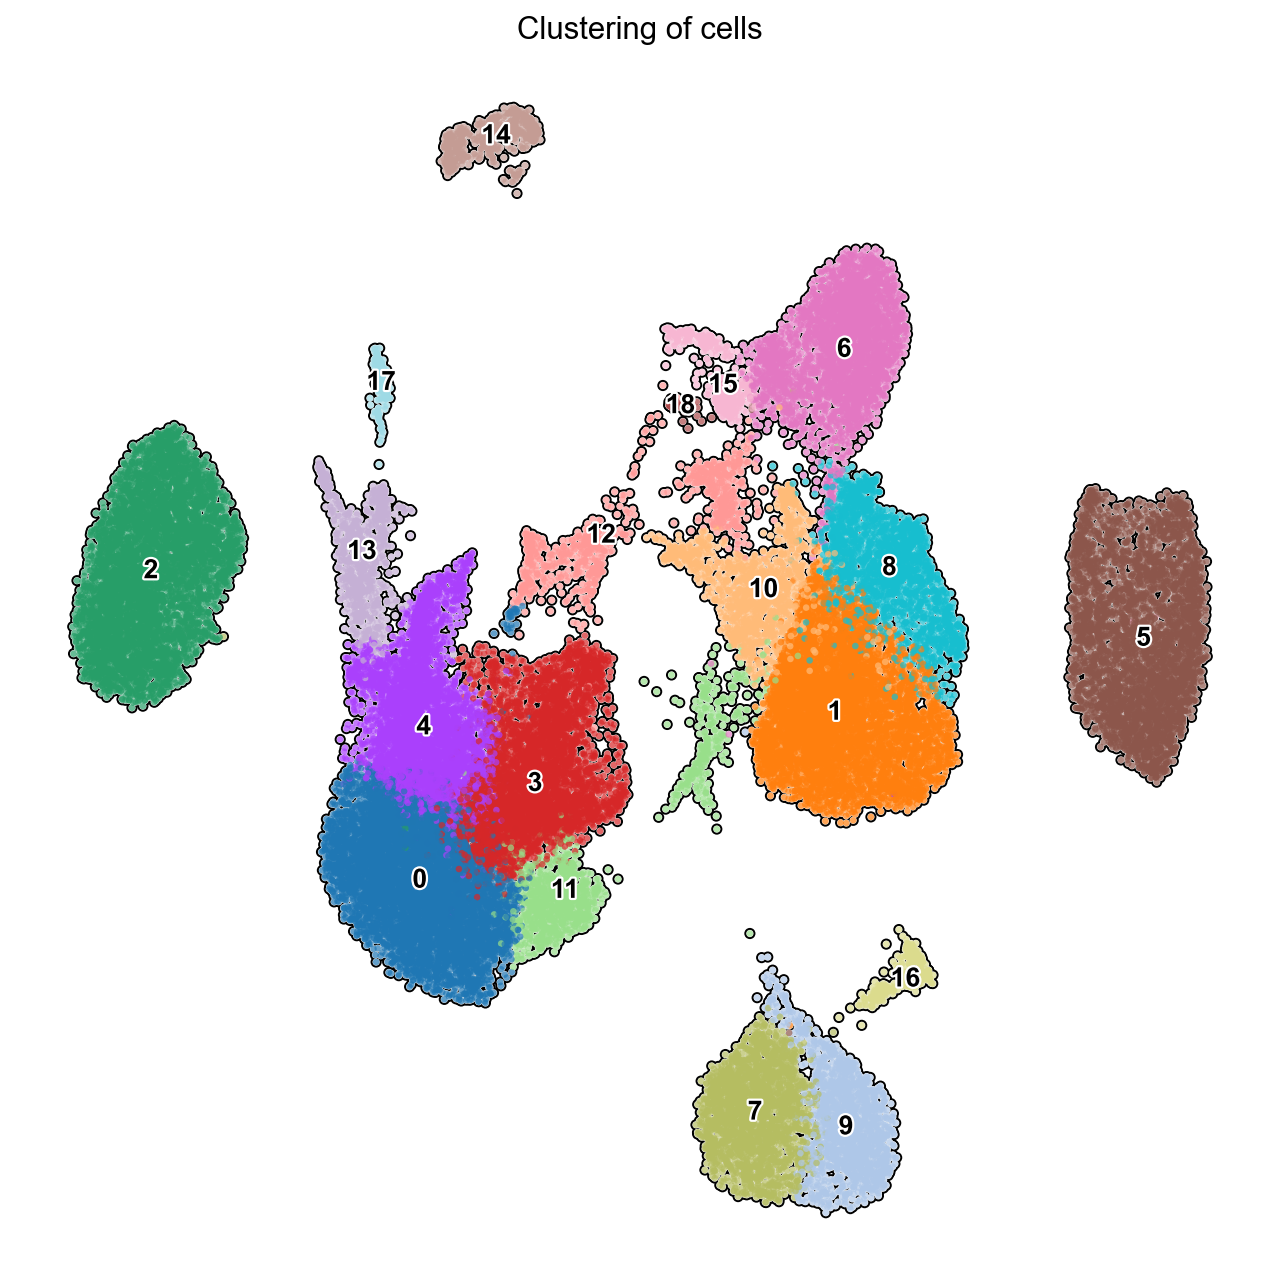

In [38]:
# Plot UMAP with the clustering results
sc.pl.umap(adata, color='leiden', add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, size=35,
           title='Clustering of cells')

In [39]:
# Check if Pax7 is in the list of genes
print(f"Available genes: {adata.raw.var_names[:10]}")  # Check first 10 gene names

Available genes: Index(['Gm29155', 'Pcmtd1', 'Exo1', 'Uxs1', 'Dsel', 'Asic4', 'Sntg1', 'Rrs1',
       'Adhfe1', 'Cep170'],
      dtype='object')


In [40]:
# Filter out genes "Gfp" and "Pax7" based on expression values
# Ensure these genes exist in the raw attribute
if 'Pax7' in adata.raw.var_names:
    ad_filtered = adata_concat[((adata_concat.raw[:, "Gfp"].X.toarray().flatten() == 0) & 
                                (adata_concat.raw[:, "Pax7"].X.toarray().flatten() == 0)), :].copy()

    # Check the filtered AnnData object
    print(ad_filtered)
else:
    print("Gene Pax7 not found in raw attribute.")

Gene Pax7 not found in raw attribute.


In [41]:
# Check if Pax7 is in raw attribute
print('Pax7' in adata.raw.var_names)  # Returns True if Pax7 is in raw


False


In [42]:
# Look for Pax7 with different casing or aliases
pax7_genes = [gene for gene in adata.var_names if 'pax7' in gene.lower()]
print(pax7_genes)


[]


In [26]:
# Filter out genes "Gfp" and "Pax7" based on expression values
ad_filtered = adata_concat[((adata_concat.raw[: , "Gfp"].X.toarray().flatten() == 0) & 
                            (adata_concat.raw[: , "Pax7"].X.toarray().flatten() == 0)), :].copy()



KeyError: 'Pax7'

In [ ]:
# Reload the saved file
adata = sc.read('Ha_integrated_data.h5ad')

# Verify raw layer and its gene dimensions
print("Raw data:", adata_concat.raw)
print("Shape of genes in raw data:", adata_concat.raw.var.shape)

In [3]:
import scanpy as sc
# Set working directory
os.chdir("P:/Tolulope/Manuscript/Yuan Analysis")
adata = sc.read('Step1_preprocessed.h5ad')

# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Subset only highly variable genes
adata = adata[:, adata.var.highly_variable]

# Regression and scaling
sc.pp.regress_out(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
# PCA computation
sc.tl.pca(adata)

In [4]:
# Apply Harmony integration
kwargs = dict(verbose=True, plot_convergence=True, max_iter_kmeans=25)
sc.external.pp.harmony_integrate(adata, key='batch', **kwargs)

# Run nearest neighbors and clustering
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_neighbors=30, n_pcs=50)

2025-03-25 16:53:56,028 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-25 16:54:04,045 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-25 16:54:04,275 - harmonypy - INFO - Iteration 1 of 10
2025-03-25 16:54:27,497 - harmonypy - INFO - Iteration 2 of 10
2025-03-25 16:54:50,683 - harmonypy - INFO - Iteration 3 of 10
2025-03-25 16:55:14,668 - harmonypy - INFO - Converged after 3 iterations


In [8]:
sc.tl.leiden(adata, resolution=1)

In [9]:
sc.tl.umap(adata)

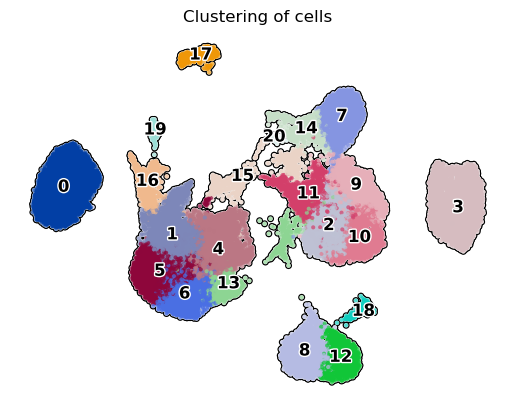

In [10]:
# Plot UMAP with the clustering results
sc.pl.umap(adata, color='leiden', add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, size=35,
           title='Clustering of cells')

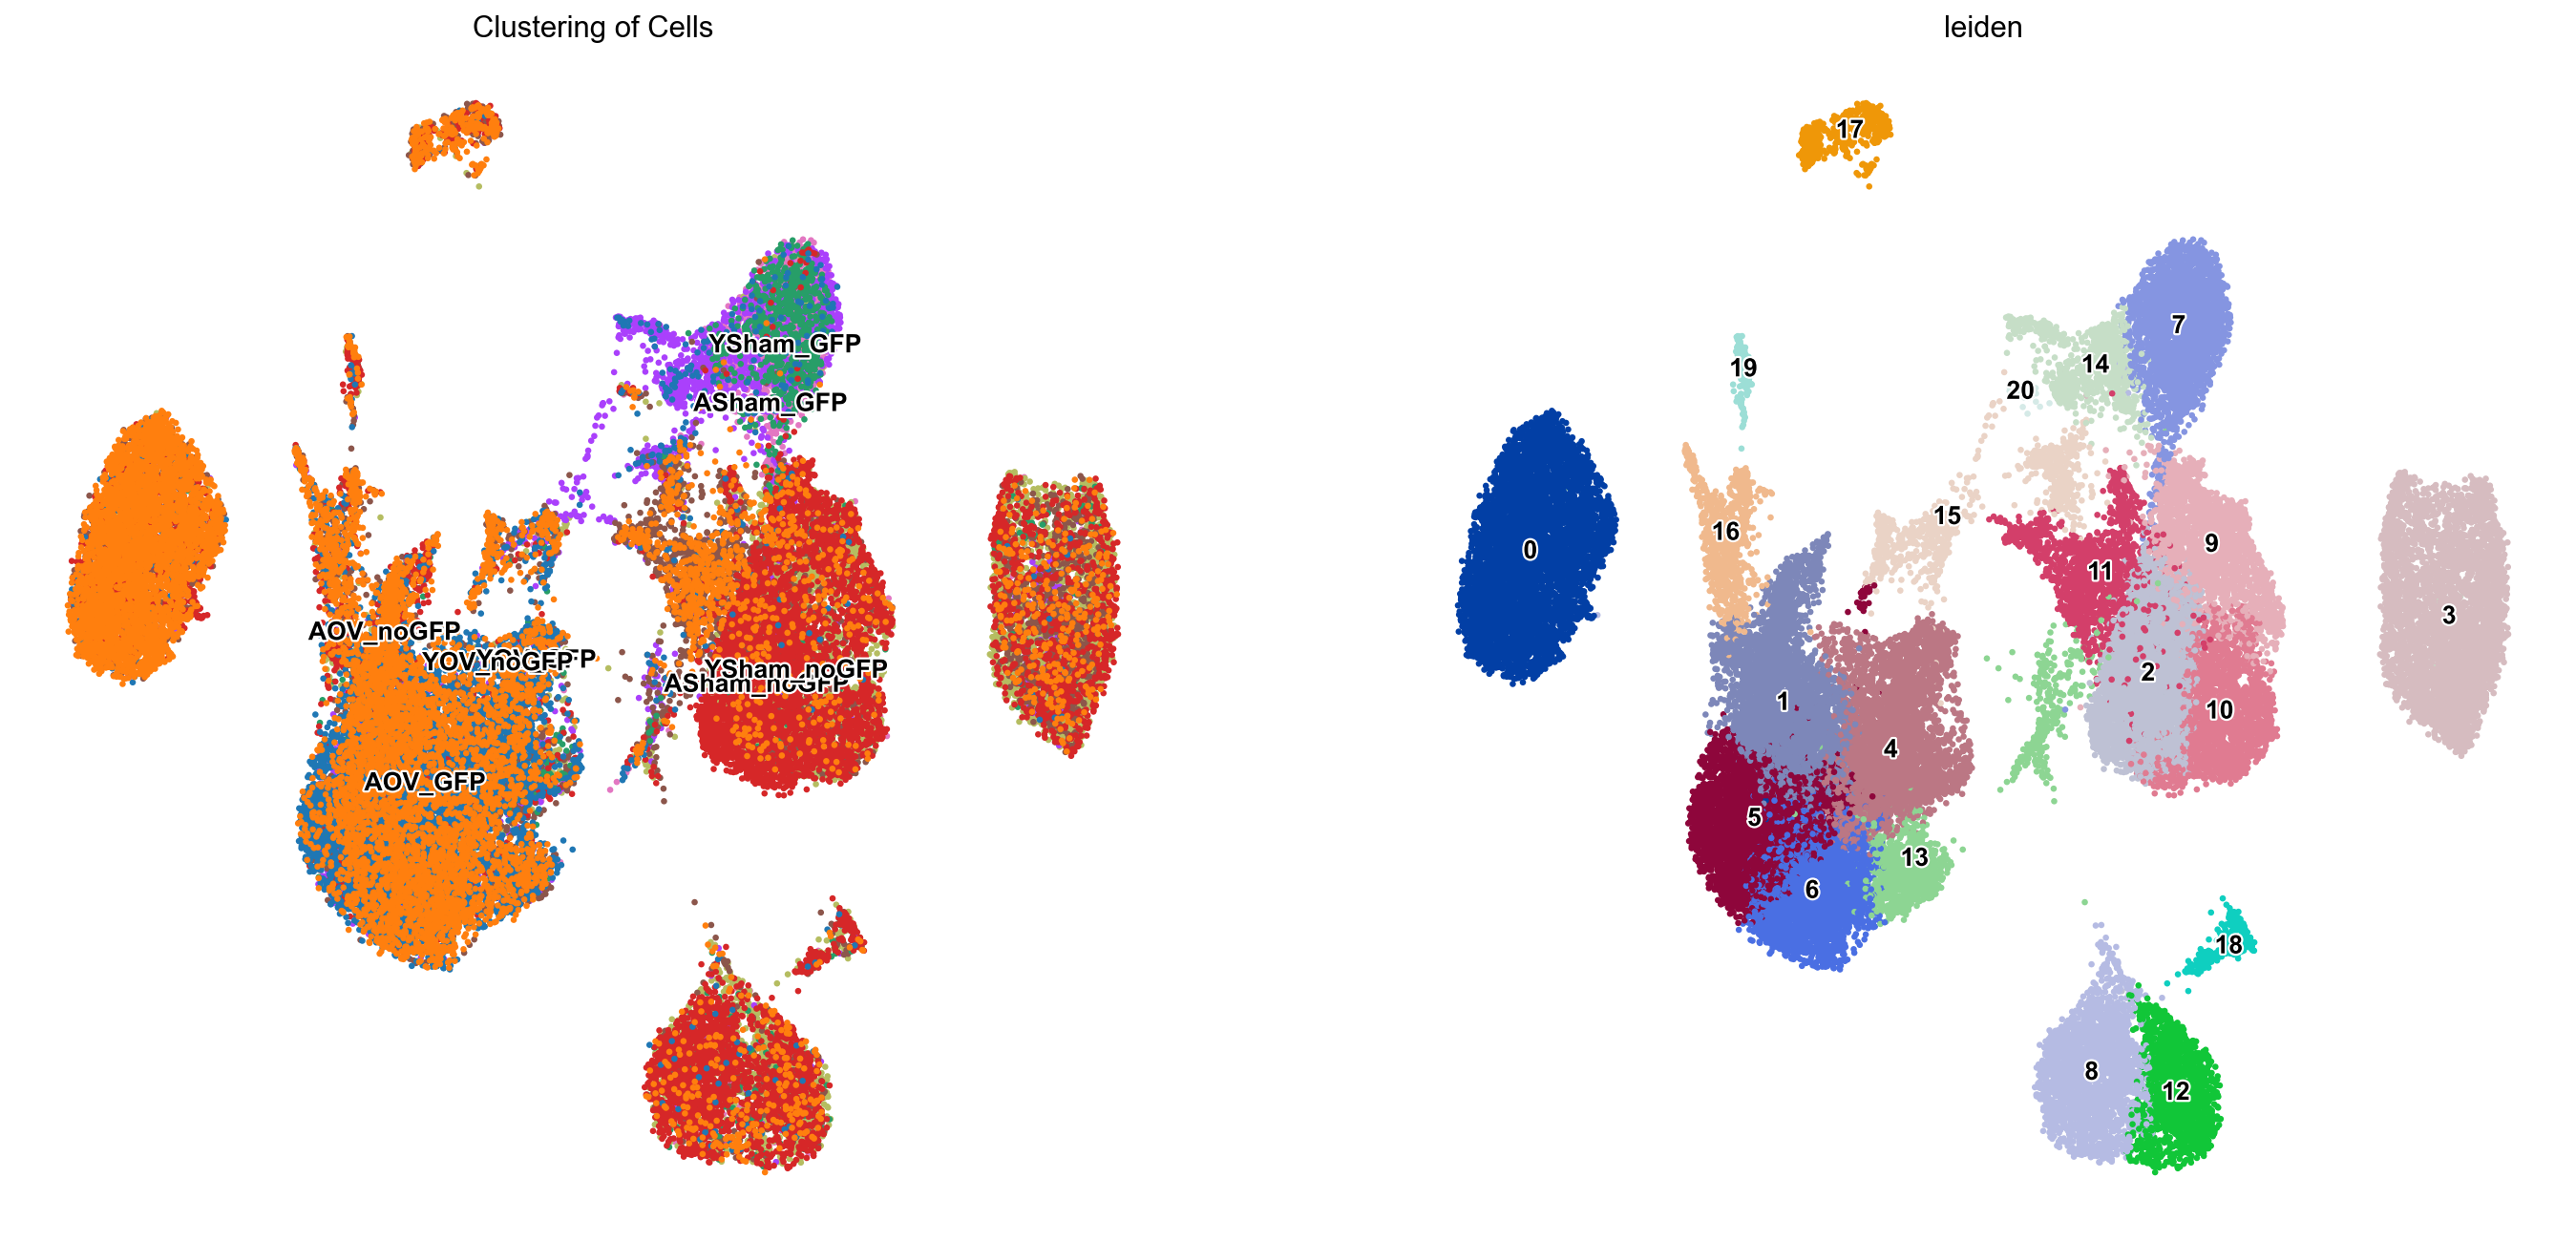

In [11]:
# Customize UMAP plot
sc.set_figure_params(figsize=(10, 10))
img_tag = "_color"  # Specify your image tag here
sc.pl.umap(adata, color=['batch', 'leiden'], legend_loc='on data', legend_fontsize=12, legend_fontoutline=2, frameon=False, size=35, title='Clustering of Cells', save=f'umap_plot after integration sample and cell type{img_tag}.png')
pl.show()

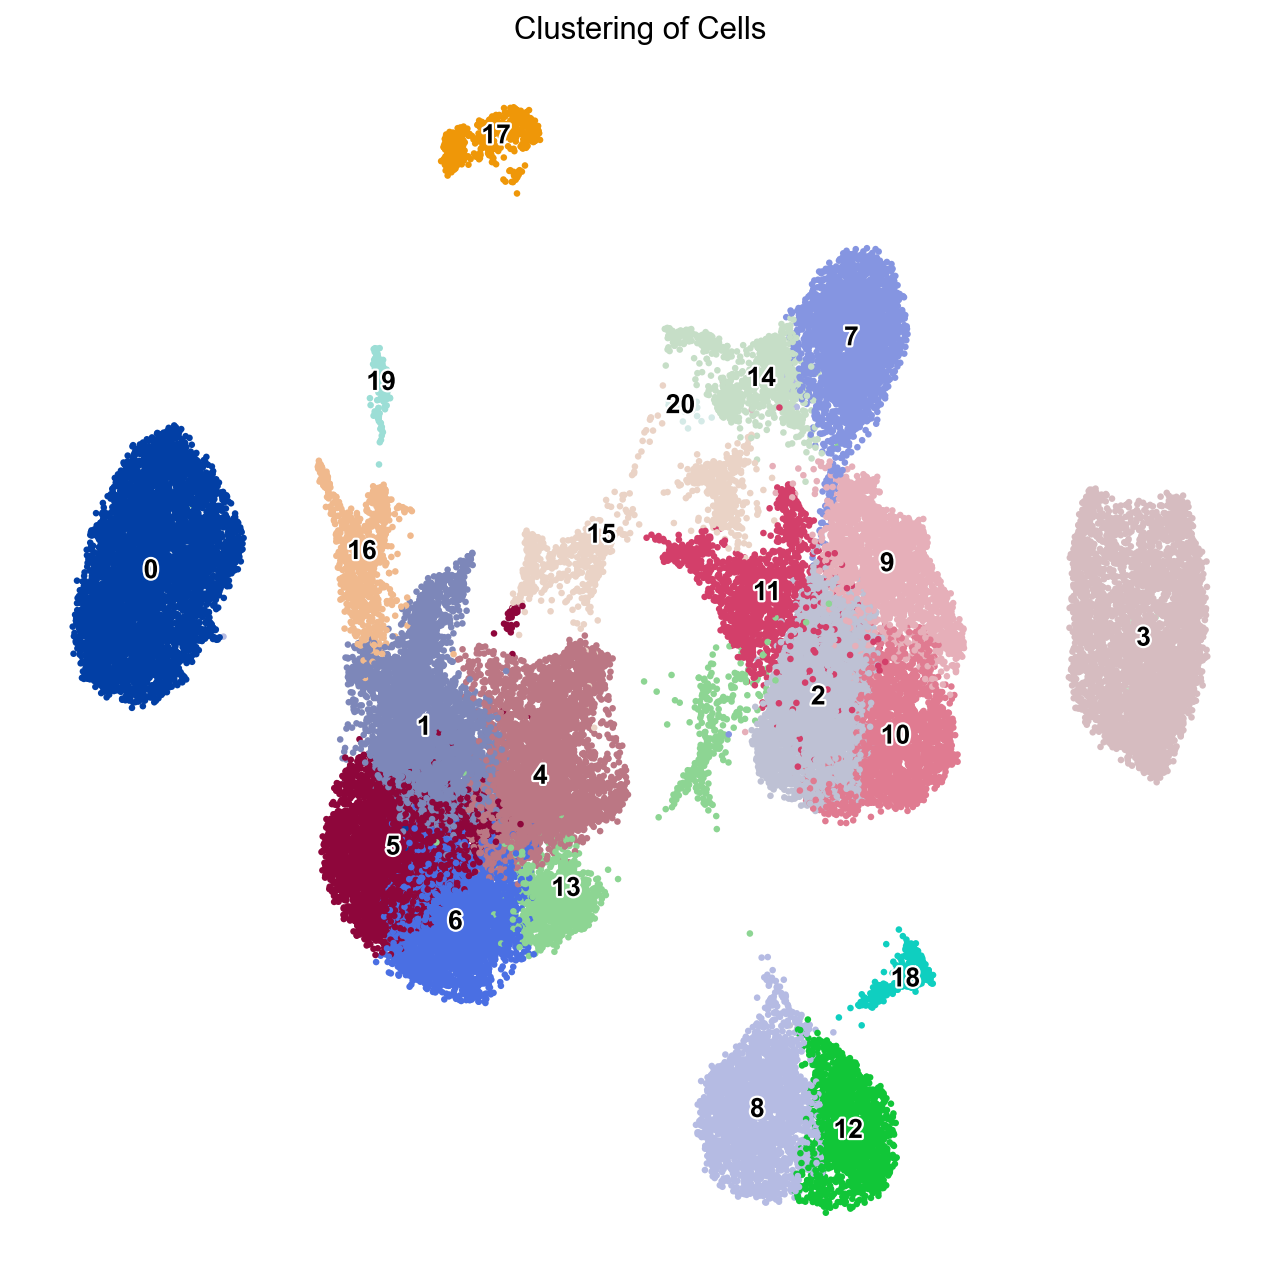

In [12]:
# Customize UMAP plot
sc.set_figure_params(figsize=(10, 10))
img_tag = "_color"  # Specify your image tag here
sc.pl.umap(adata, color=['leiden'], legend_loc='on data', legend_fontsize=12, legend_fontoutline=2, frameon=False, size=35, title='Clustering of Cells', save=f'umap_plot after integration sample and cell type{img_tag}.png')
pl.show()

In [13]:
# Save integrated data
adata.write('Ha_integrated_data.h5ad')

In [14]:
# Make a copy of the integrated data
adata_concat = adata.copy()

In [27]:
# Reload the saved file
adata = sc.read('Ha_integrated_data.h5ad')

# Verify raw layer and its gene dimensions
print("Raw data:", adata_concat.raw)
print("Shape of genes in raw data:", adata_concat.raw.var.shape)

KeyboardInterrupt: 

In [16]:
# Corrected filtering step using `raw.to_adata()`
raw_data = adata_concat.raw.to_adata()
ad_filtered = raw_data[((raw_data[:, "Gfp"].X.toarray().flatten() == 0) & 
                            (raw_data[:, "Pax7"].X.toarray().flatten() == 0)), :].copy()

print(ad_filtered)

KeyError: 'Pax7'

In [ ]:
adata = sc.read('Step4_integrated.h5ad')

# Convert raw to full matrix before filtering
raw_data = adata.raw.to_adata()

# Extract only cells with no Gfp and Pax7 expression
filtered_cells = (raw_data[:, "Gfp"].X.toarray().flatten() == 0) & \
                 (raw_data[:, "Pax7"].X.toarray().flatten() == 0)

ad_filtered = raw_data[filtered_cells, :].copy()

# Save filtered data
ad_filtered.write('Step5_filtered.h5ad')



In [71]:
import os
import scanpy as sc
import numpy as np
import anndata  # Ensure to import anndata

# Set working directory
os.chdir("P:/Tolulope/Manuscript/Yuan Analysis")

# List of .h5ad files and corresponding sample names
samples = {
    'YSham_GFP_adata_filtered_with_SOLO.h5ad': 'YSham_GFP',
    'YSham_noGFP_adata_filtered_with_SOLO.h5ad': 'YSham_noGFP',
    'YOV_GFP_adata_filtered_with_SOLO.h5ad': 'YOV_GFP',
    'YOV_noGFP_adata_filtered_with_SOLO.h5ad': 'YOV_noGFP',
    'ASham_GFP_adata_filtered_with_SOLO.h5ad': 'ASham_GFP',
    'ASham_noGFP_adata_filtered_with_SOLO.h5ad': 'ASham_noGFP',
    'AOV_GFP_adata_filtered_with_SOLO.h5ad': 'AOV_GFP',
    'AOV_noGFP_adata_filtered_with_SOLO.h5ad': 'AOV_noGFP'
}

# Define preprocessing function
def preprocess_adata(adata):
    """Preprocess an AnnData object before concatenation."""
    adata.var_names_make_unique()
    sc.pp.filter_cells(adata, min_genes=200)  # Remove cells with <200 genes
    sc.pp.filter_genes(adata, min_cells=3)  # Remove genes found in <3 cells

    # Annotate mitochondrial genes
    adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
    
    # Identify hemoglobin genes, excluding those starting with "HbP"
    adata.var['hb'] = adata.var_names.str.contains(r'^Hb(?!P)', regex=True)
    
    # Remove hemoglobin genes
    adata = adata[:, ~adata.var['hb']]

    # Calculate quality control (QC) metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

    # Remove cells with high mitochondrial content (>5%)
    adata = adata[adata.obs.pct_counts_mt < 5]

    return adata

# Process each file and store preprocessed objects
out = []
for file, sample_name in samples.items():
    file_path = os.path.join("P:/Tolulope/Manuscript/Yuan Analysis", file)
    if os.path.exists(file_path):  # Ensure file exists
        adata = sc.read_h5ad(file_path)  # Load .h5ad file
        adata = preprocess_adata(adata)  # Preprocess the data
        adata.obs["Sample"] = sample_name  # Assign sample name
        out.append(adata)  # Append preprocessed data to list
    else:
        print(f"File not found: {file_path}")

# Concatenate the list of preprocessed AnnData objects
if out:
    adata_concat = anndata.concat(out, label="Sample", keys=list(samples.values()))
    results_file = 'adata_concat.h5ad'
    adata_concat.layers['counts'] = adata_concat.X.copy()
    adata_concat.write(results_file)

    # Display the number of cells in each sample
    print(adata_concat.obs['Sample'].value_counts())
    adata_concat.raw = adata_concat


    adata = adata_concat.copy()

    # Normalize and log-transform data
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Identify highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    
    adata = adata[:, adata.var.highly_variable]
    sc.pp.regress_out(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'])
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata)

else:
    print("No valid AnnData files to process.")


Sample
AOV_noGFP      10131
ASham_noGFP     9074
YSham_noGFP     6930
YOV_noGFP       6783
AOV_GFP         6231
YOV_GFP         3660
YSham_GFP       1739
ASham_GFP       1280
Name: count, dtype: int64


In [72]:
adata

AnnData object with n_obs × n_vars = 45828 × 3696
    obs: 'batch', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Sample'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [73]:
adata

AnnData object with n_obs × n_vars = 45828 × 3696
    obs: 'batch', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Sample'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [74]:
# Apply Harmony integration (before PCA or other dimensionality reductions)
# We are passing the PCA results here, so the batch correction will occur in PCA space
kwargs = dict(verbose=True, plot_convergence=True, max_iter_kmeans=25)
sc.external.pp.harmony_integrate(adata, key='batch', **kwargs)

# Run nearest neighbors using the Harmony-corrected PCA
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_neighbors=30, n_pcs=50)

2025-03-25 15:52:01,780 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-25 15:52:05,258 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-25 15:52:05,437 - harmonypy - INFO - Iteration 1 of 10
2025-03-25 15:52:19,246 - harmonypy - INFO - Iteration 2 of 10
2025-03-25 15:52:33,054 - harmonypy - INFO - Iteration 3 of 10
2025-03-25 15:52:47,264 - harmonypy - INFO - Converged after 3 iterations


In [75]:
# Perform Leiden clustering
sc.tl.leiden(adata,resolution=0.9)

In [76]:
# Perform UMAP for visualization
sc.tl.umap(adata)

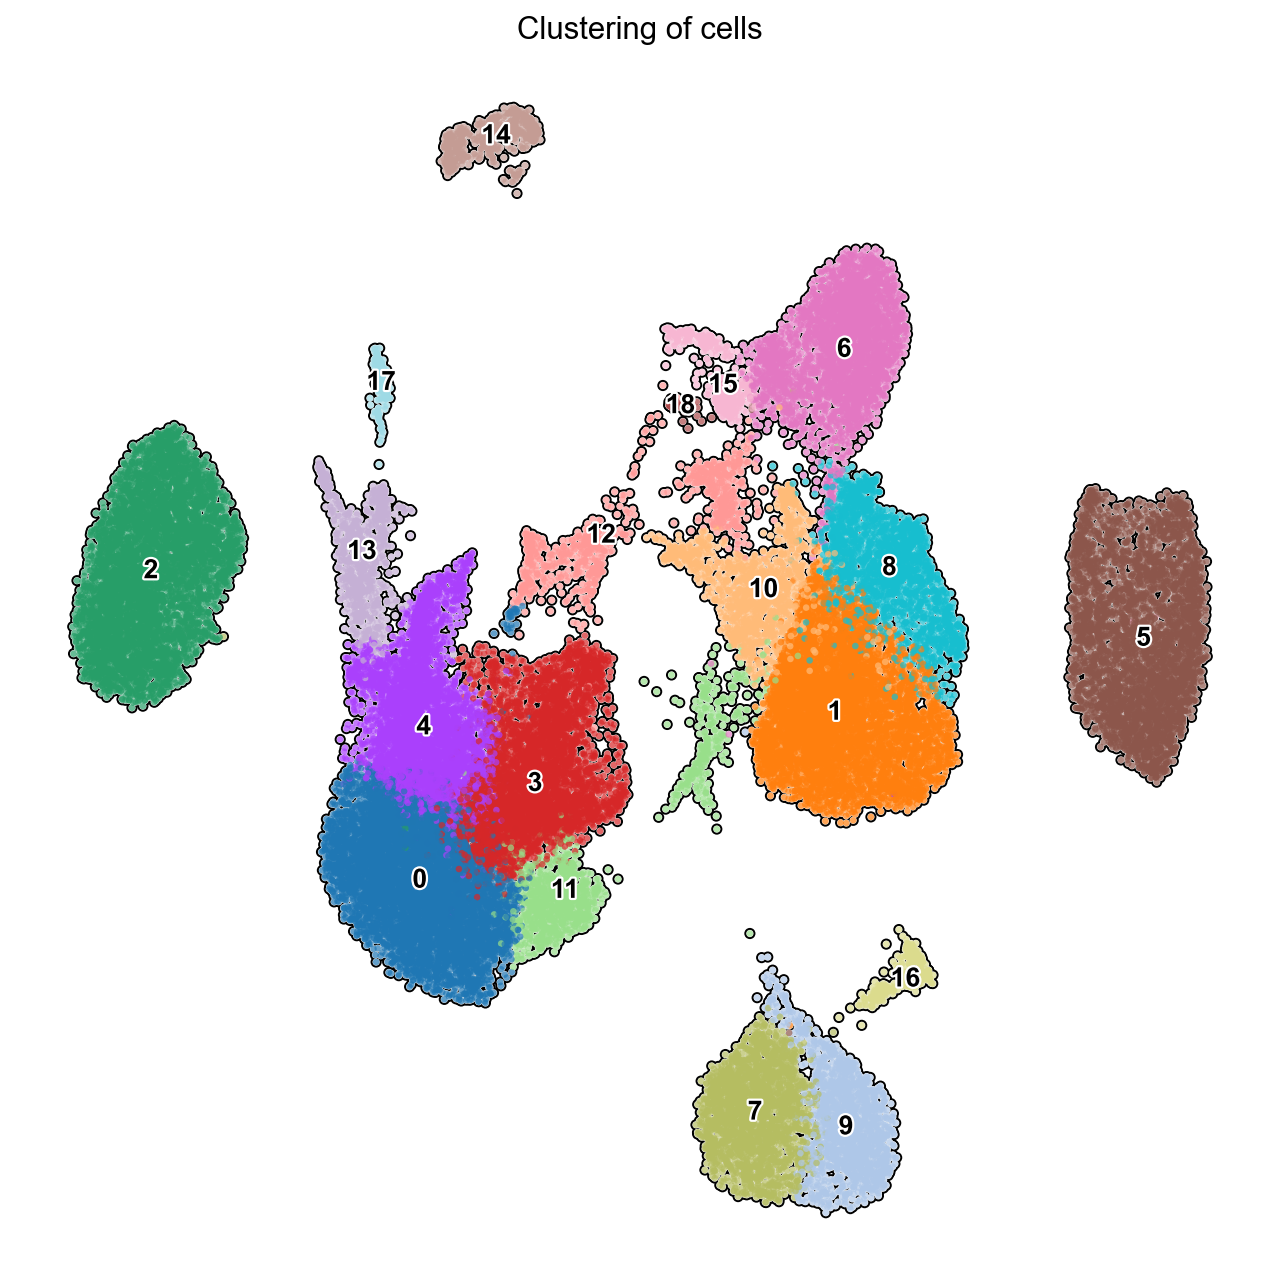

In [77]:
# Plot UMAP with the clustering results
sc.pl.umap(adata, color='leiden', add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, size=35,
           title='Clustering of cells')

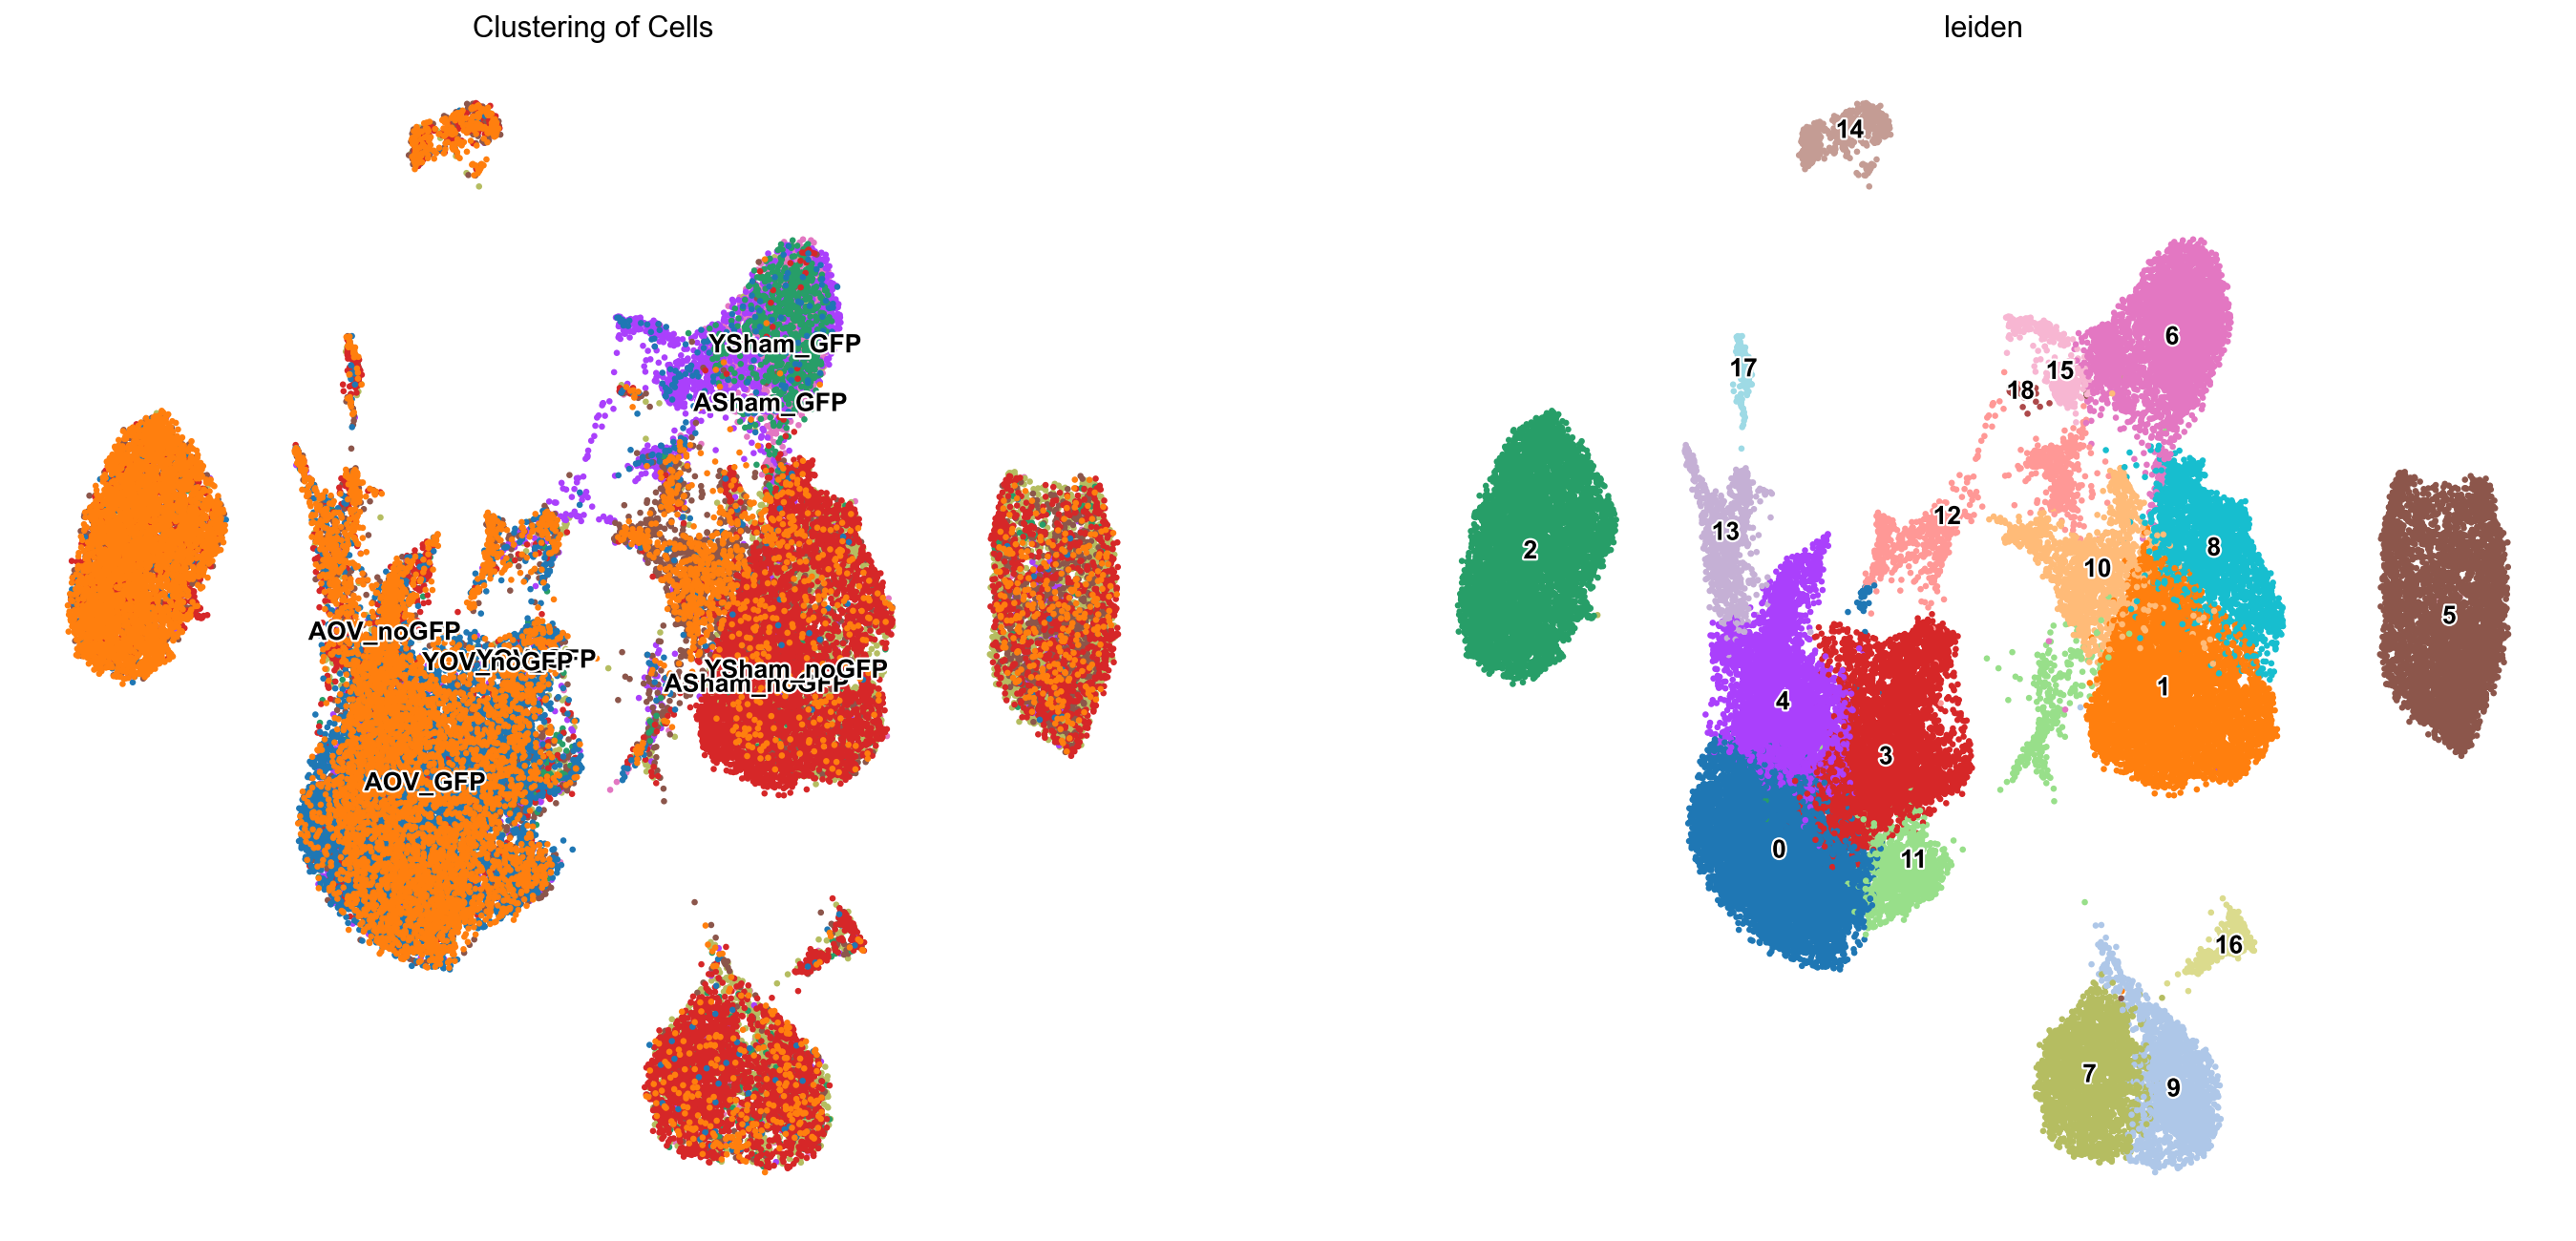

In [78]:
# Customize UMAP plot
sc.set_figure_params(figsize=(10, 10))
img_tag = "_color"  # Specify your image tag here
sc.pl.umap(adata, color=['batch', 'leiden'], legend_loc='on data', legend_fontsize=12, legend_fontoutline=2, frameon=False, size=35, title='Clustering of Cells', save=f'umap_plot after integration sample and cell type{img_tag}.png')
pl.show()

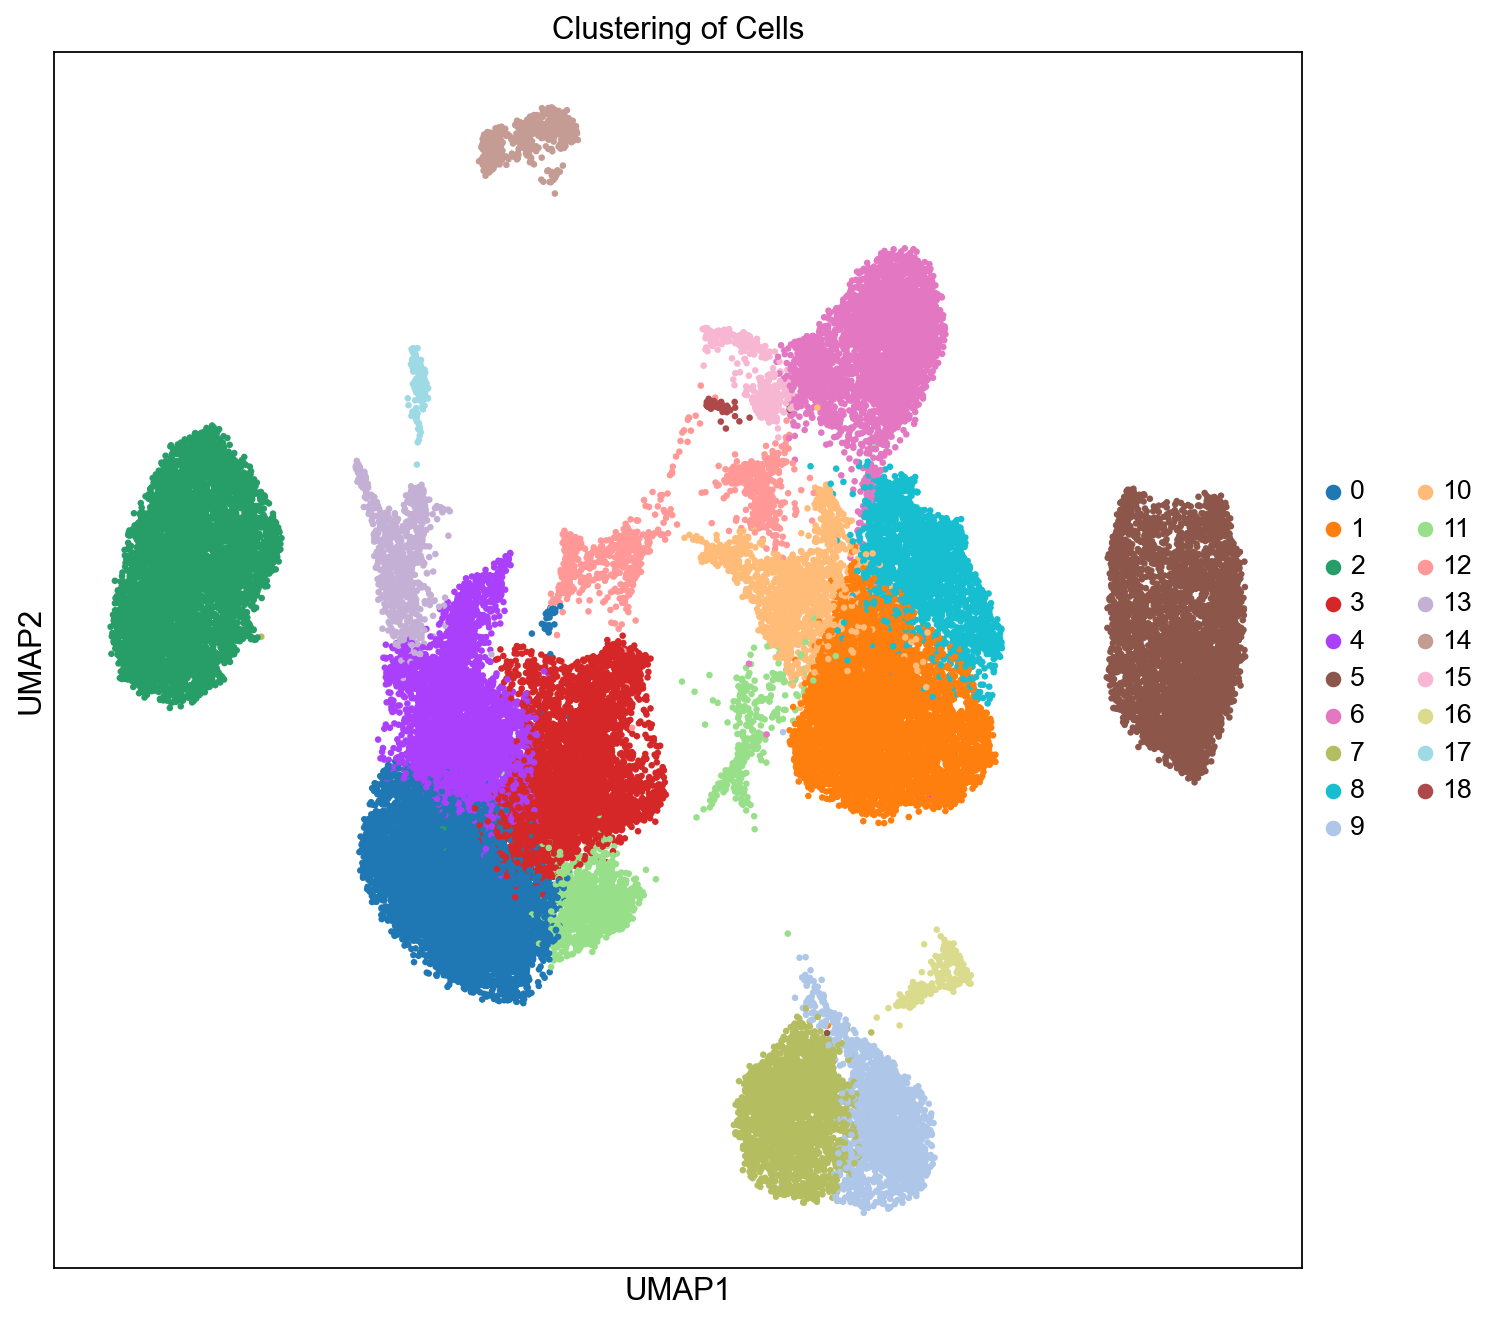

In [79]:

# Customize UMAP plot
sc.set_figure_params(figsize=(10, 10))
img_tag = "_color"  # Specify your image tag here
sc.pl.umap(adata, color=['leiden'],  legend_fontsize=12, legend_fontoutline=2, frameon=True, size=35, title='Clustering of Cells', save=f'umap_plot after intesample1{img_tag}.png')
pl.show()

In [80]:
adata.write('Ha_integrated_data.h5ad')
adata_concat=adata.copy()

In [81]:
results_file="Ha_integrated_data.h5ad"
adata=sc.read(results_file)
adata_concat=adata.copy()

In [69]:
print(adata_concat.raw)
print(adata_concat.raw.var.shape)

Raw AnnData with n_obs × n_vars = 45828 × 18625
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
(18625, 4)


In [82]:
ad_filtered = adata_concat[((adata_concat.raw[: , "Gfp"].X.toarray().flatten() ==0) & (adata_concat.raw[: , "Pax7"].X.toarray().flatten() ==0)), :].copy()
#ad_filtered = adata_concat[(adata_concat.raw[: , "Gfp"].X.toarray().flatten() ==0) , :].copy()
print(ad_filtered)

KeyError: 'Pax7'

In [58]:
# Set figure size
pl.rcParams['figure.figsize'] = 3, 2

# Scatter plot of Pax7 vs Gfp and save it
sc.pl.scatter(adata, x="Pax7", y="Gfp", size=10, save=f"umap_correlation_{img_tag}.png")


ValueError: `x`, `y`, and potential `color` inputs must all come from either `.obs` or `.var`